# Import all necessary libraries

In [152]:
import pandas as pd
import numpy as np
import re
from bs4 import BeautifulSoup
import seaborn as sns
import matplotlib.pyplot as plt
import folium
import requests

# Import all the datasets

In [153]:
cartheft_toronto = pd.read_csv('/Users/prithvishams/Documents/Bootcamp Concordia/Module 1 Captsone Project/Auto_Theft_Open_Data.csv') #cartheft data in Toronto from 2014 to 2019
canada_crimes = pd.read_excel('/Users/prithvishams/Documents/Bootcamp Concordia/Module 1 Captsone Project/EDA Canada Crimes.xlsx') #Canada crimes statistics
edmonton_crimes = pd.read_csv('/Users/prithvishams/Documents/Bootcamp Concordia/Module 1 Captsone Project/EPS_Neighbourhood_Criminal_Incidents.csv') #Edmonton crimes statistics
vancouver_crimes = pd.read_csv('/Users/prithvishams/Documents/Bootcamp Concordia/Module 1 Captsone Project/crime_records.csv') #Vancouver crime statistics
montreal_crimes = pd.read_csv('/Users/prithvishams/Documents/Bootcamp Concordia/Module 1 Captsone Project/Montreal Crime Data.csv') #Montreal crime statistics
toronto_crimes = pd.read_csv('/Users/prithvishams/Documents/Bootcamp Concordia/Module 1 Captsone Project/MCI_2021.csv') #Toronto major crimes 2021 - 2022
unemployment = pd.read_csv('/Users/prithvishams/Documents/Bootcamp Concordia/Module 1 Captsone Project/unemploymentrate.csv') #unemployment figures for different provinces from 1976 to 2014

# 1 Most dangerous province
Data obtained from Statistics Canada table number 35-10-0177-01 released on 2021-07-27: <span style = "color:orange;">incident-based-crime-data-in-canada</span><br>
Dataset shows crime statistics from 2000 to 2020 <br>
I only included specific crime types which I consider *violent* <br>
The bar chart below shows that violent crime is not all that common in Canada. Theft below $5000 is the most common type of *violent* crime, followed by auto theft. Ontario leads in all kinds of violent crimes followed by Quebec. This is expected, considering that most of the Canadian population is concentrated in Ontario and Quebec. <br>
The line chart for per capita crime rate shows the opposite trend: sparsely populated Atlantic and prairie provinces appear to have higher crime rate than the more densely populated provinces of ON and QC.<br>
Clearly, absolute number of incidents do not portray the full picture!

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Violent crimes in different provinces')

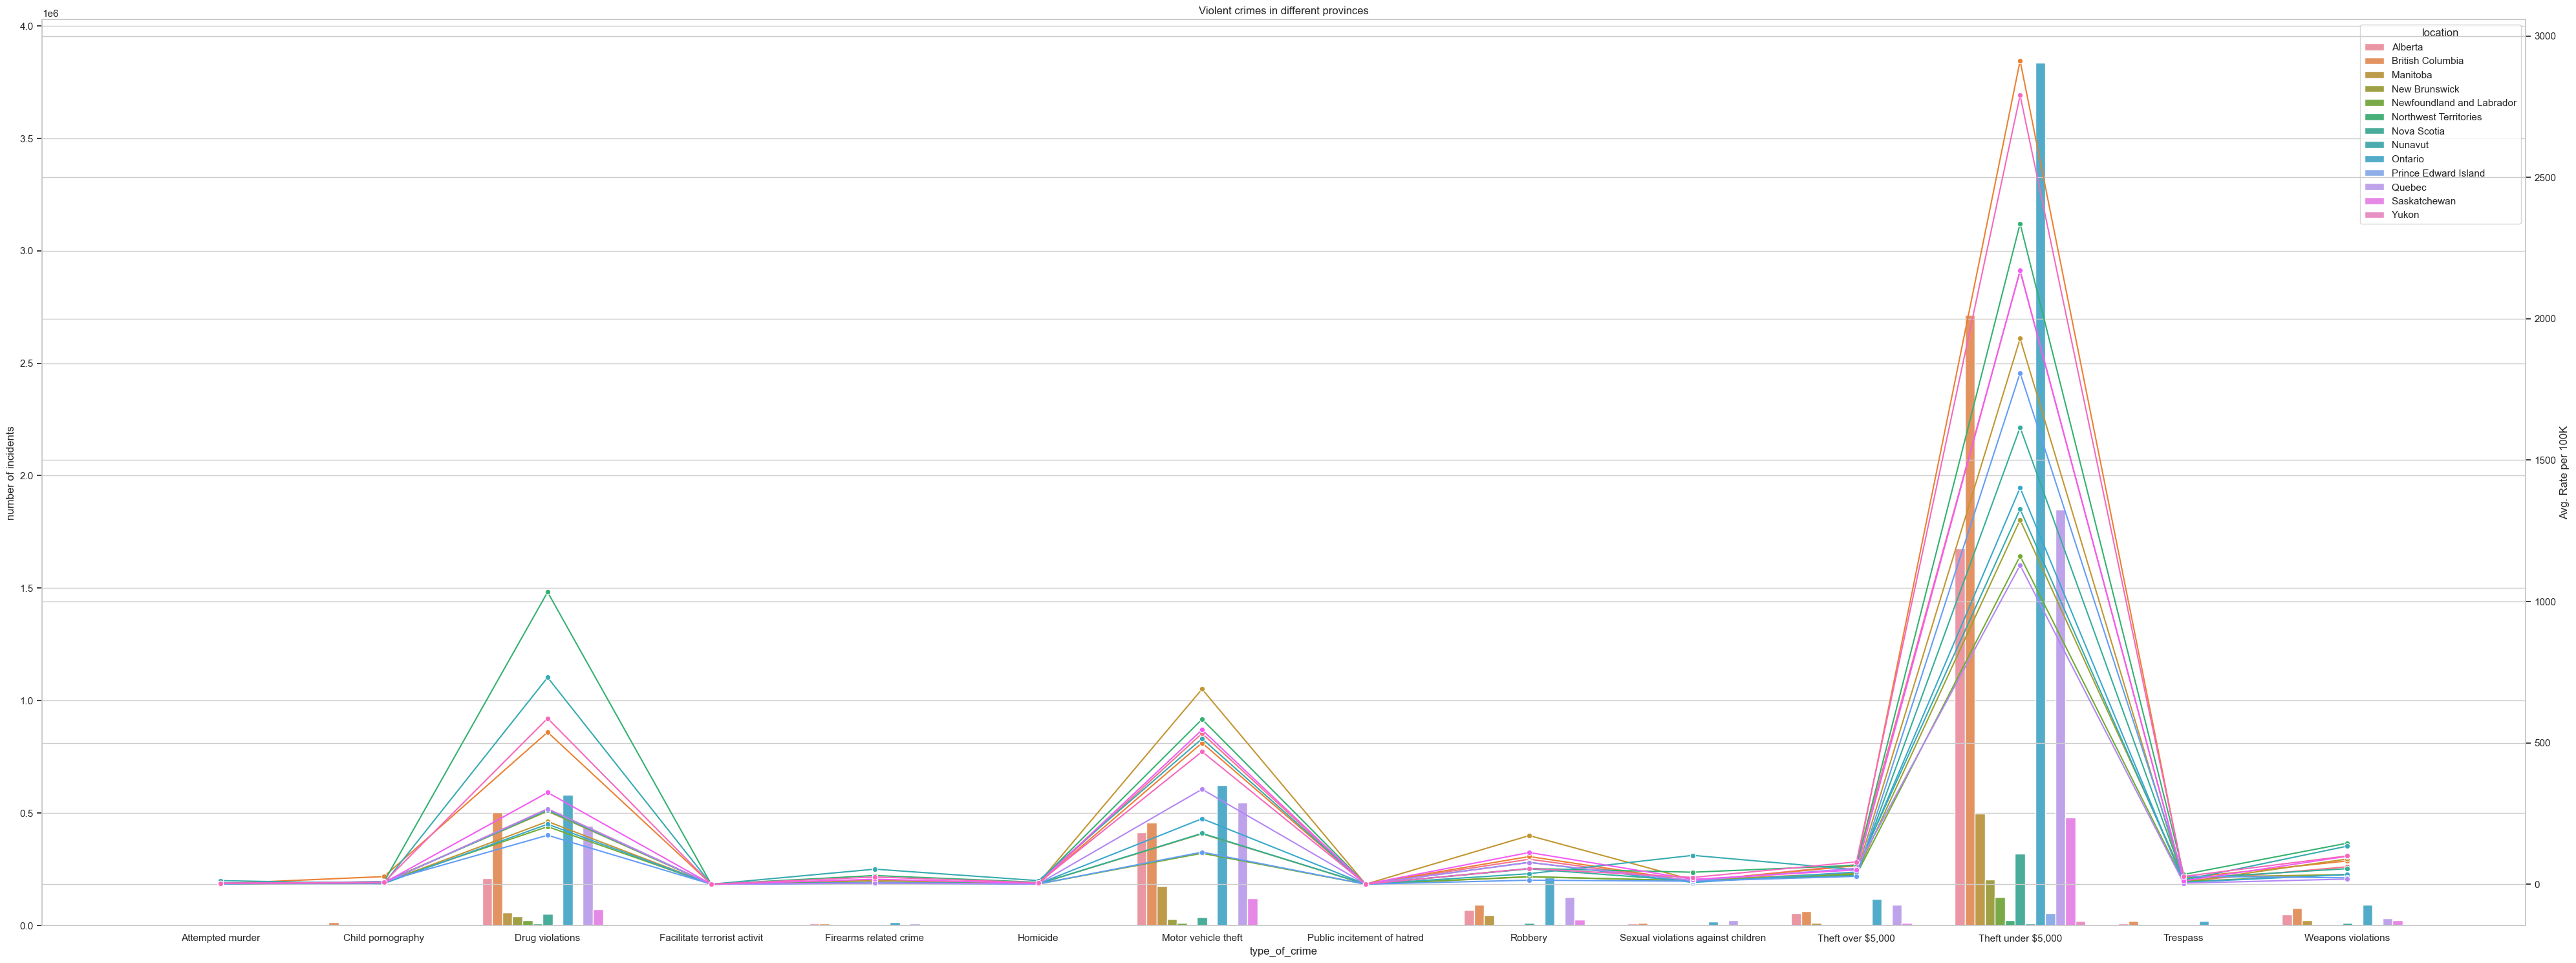

In [154]:
canada_crimes["type_of_crime"].unique() #what are the different types of crime
nonviolent_offence = ['Counterfeiting','Fraud','Impaired driving','Prostitution'] #I consider these to be non-violent or non-dangerous crime
canada_crimes_violent = canada_crimes[~canada_crimes['type_of_crime'].isin(nonviolent_offence)] #filtering out non-violent crimes

df1 = canada_crimes_violent.groupby(['location','type_of_crime'])['incidents'].sum().reset_index(name='number of incidents') #sum of incidents by province and type of crime
avg_rate = canada_crimes_violent.groupby(['location','type_of_crime'])['rate_per_100k'].mean().reset_index(name='avg rate per 100k') #avr rate by province and type of crime
df1 = df1.merge(avg_rate,on=['location','type_of_crime']) #merge into a single df to be used for plotting


sns.set(style='whitegrid')

#create the canvas
fig, ax1 = plt.subplots(figsize=(40,15))

sns.barplot(data=df1,x='type_of_crime',y='number of incidents',hue='location',ax=ax1,)

#create a second y-axis for average rate per 100k
ax2 = ax1.twinx()
ax2.set_ylabel('Avg. Rate per 100K')

#create a line plot for ax2

sns.lineplot(data=df1,x='type_of_crime',y='avg rate per 100k',hue='location',marker='o',ax=ax2,legend=False)
fig.tight_layout()

plt.title("Violent crimes in different provinces")


# 2 Where are you mostly likely to have your car stolen

Car theft has decreased over the years, in spite of how it's made out to be by media outcries. <br>

In the first decade post-2000, Manitoba largely led the country in per capita vehicle theft <br>

That mantle now goes to Alberta! <br>

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Car theft per province')

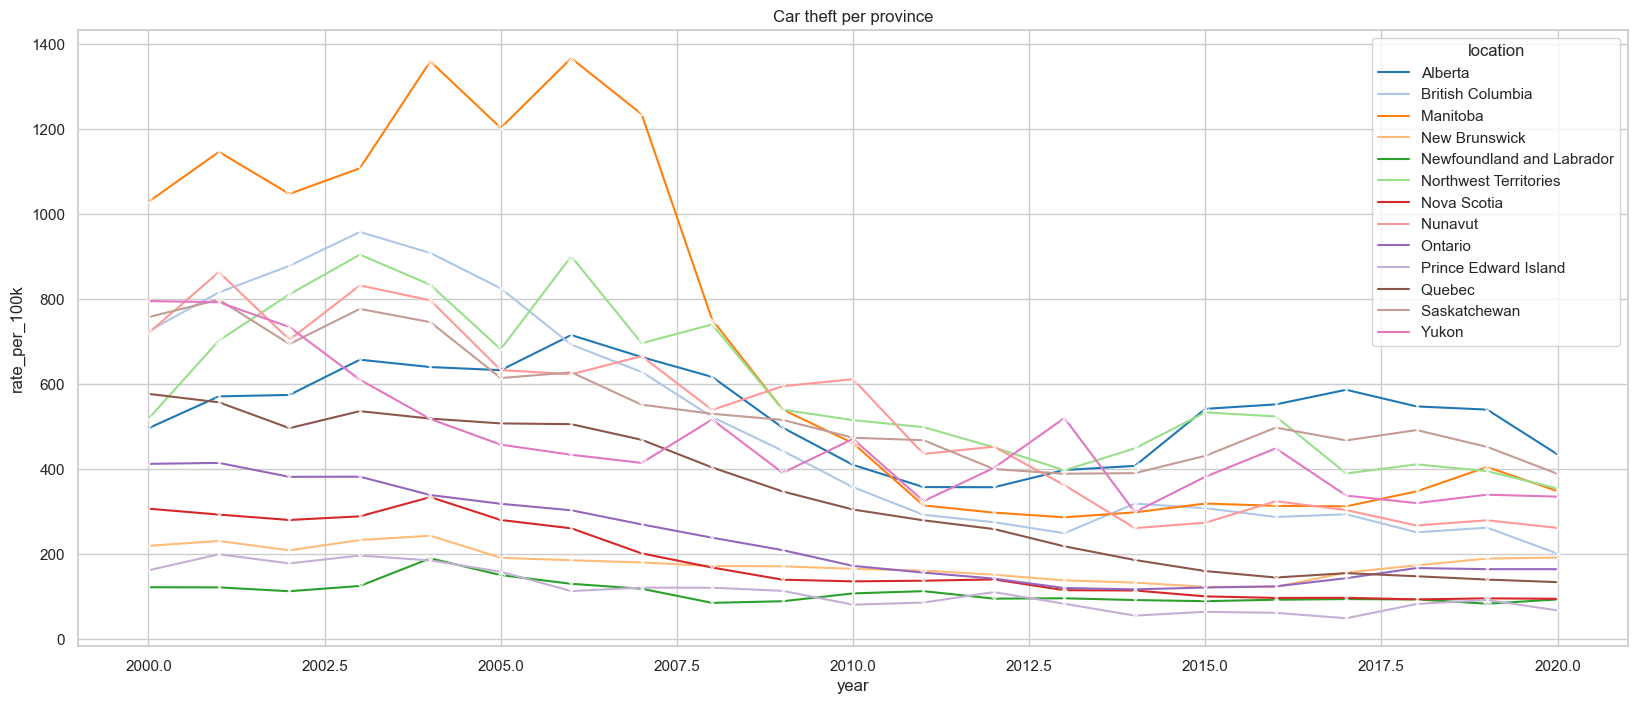

In [155]:
df2 = canada_crimes[canada_crimes['type_of_crime']=='Motor vehicle theft'] #Filtering by motor vehicle theft

fig, ax3 =plt.subplots(figsize=(20,8))
sns.lineplot(data = df2, x = 'year', y = 'rate_per_100k', hue = 'location', marker = 'x', ax=ax3, palette = 'tab20') #using tab20 color palette because seaborn default palette is insufficient for 13 provinces
plt.title('Car theft per province')

# 3 Home Invasion map of Montreal

I was always curious about generating maps with Python library, so I took this opportunity to plot home invsaions in Montreal for the year 2021 using the **folium** library. <br>

Zooming in, it appears that home invasions are most concentrated in the central district of Montreal. Living in Montreal, I am not surprised considering that this is also the most densely populated region of Montreal.

In [156]:
crime_map = folium.Map(location=[45.4, -74.00],zoom_start=10) #initializing the map around Montreal

#filter data frame for home invasions in 2021
df3 = montreal_crimes[(montreal_crimes['year']==2021) & (montreal_crimes['category']=='Home Invasion')]

#use Montreal police logo as custom marker on map
icon_image = "https://upload.wikimedia.org/wikipedia/fr/thumb/c/cd/%C3%89cusson_SPVM_2018.png/548px-%C3%89cusson_SPVM_2018.png?20200509151551"

#plot marker on the map for each row of the dataframe
for idx, row in df3.iterrows():
    icon = folium.CustomIcon(icon_image, icon_size=(30, 20), popup_anchor=(-3, -76))
    folium.Marker(
        location = [row['latitude'],row['longitude']],
        popup=row['category'],
        icon=icon
        ).add_to(crime_map)

crime_map


# 4 Did crime in Montreal increase with population growth over the years?

Population data obtained from [this](https://www.macrotrends.net/global-metrics/cities/20384/montreal/population) site. The site blocks web scraping, so I copied the population data to an Excel spreadsheet. <br>

The chart shows crime rate does not necessarily increase with population size alone. Clearly, economic factors play a role as well.

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Montreal crime trend with population growth')

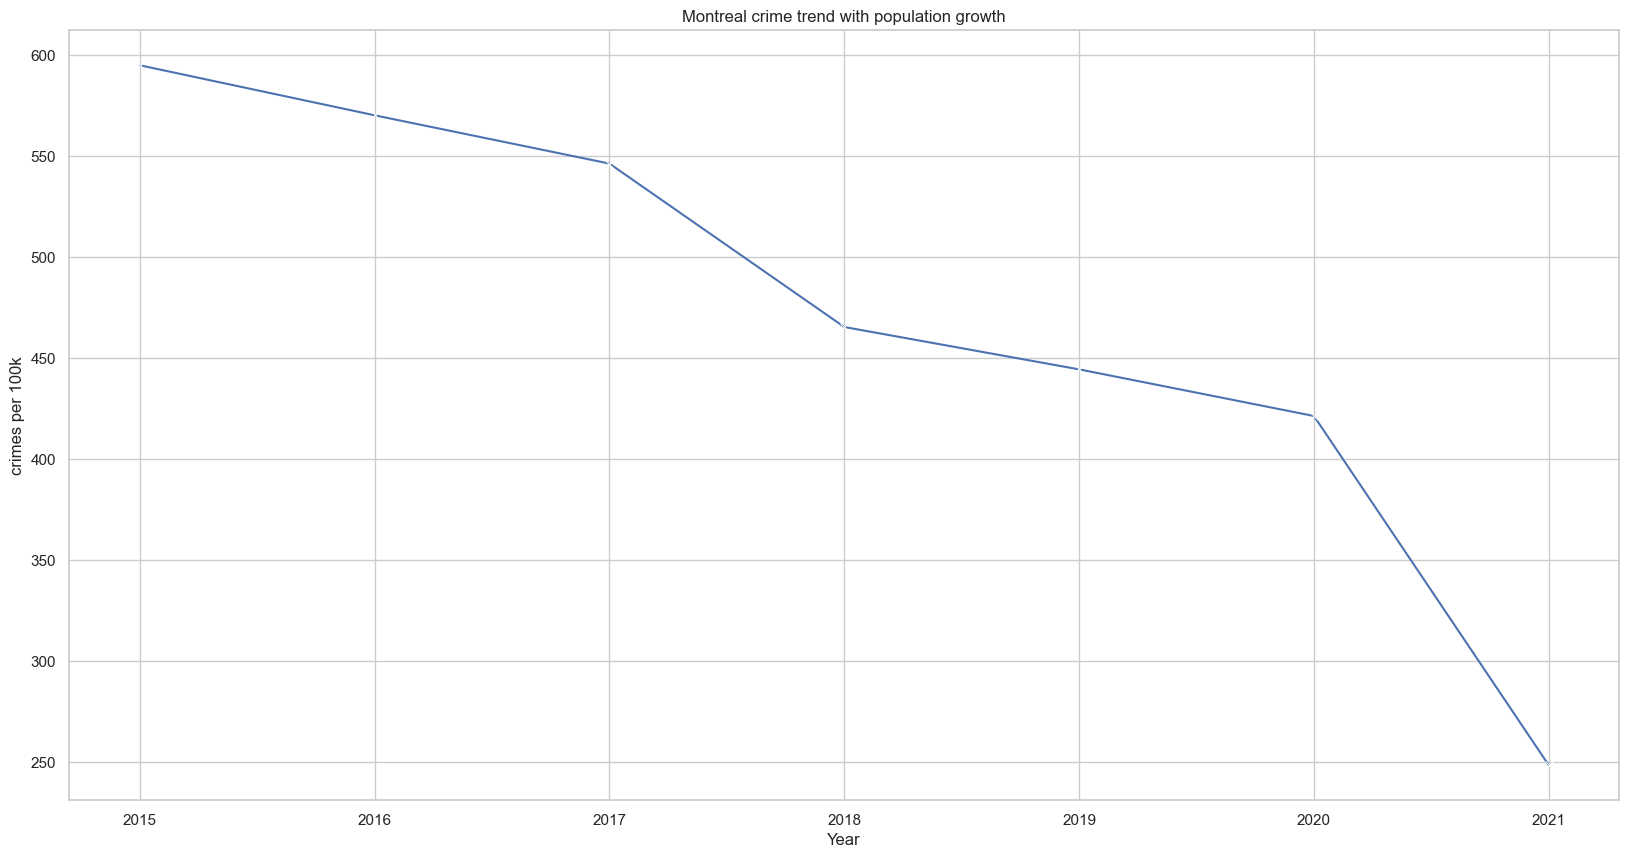

In [157]:
mtl_pop = pd.read_excel('/Users/prithvishams/Documents/Bootcamp Concordia/Module 1 Captsone Project/Mtl pop data.xlsx')

timespan = list(np.linspace(2015,2021,7)) # setting up filter criteria for years

df4 = mtl_pop[mtl_pop['Year'].isin(timespan)].sort_values('Year',ascending=True) #filtering population data by year

df5 = montreal_crimes.groupby('year')['year'].count().reset_index(name='total crimes') #aggregating crimes by year

df5.rename(columns={'year':'Year'},inplace=True) # renaming column before merging dataframe

df4 = df4.merge(df5,on='Year') #merge datafrane to calculate per capita crime rate for montreal

df4['crimes per 100k'] = df4['total crimes'] / df4['Population'] * 100000 #create derived column in dataframe

fig, ax = plt.subplots(figsize=(20,10)) #create canvas

sns.lineplot(data = df4, x = 'Year', y = 'crimes per 100k',ax = ax,marker='x')

ax.set_title('Montreal crime trend with population growth')

# 5 Is there a corelation between unemployment rate and crime?

Analysing the data for Ontario, Albert and Quebec between 2000 and 2015 or 15 year olds and older demographic, I got a correlation coefficient of -0.69 between unemployment rate and crimes per 100k. This implies that crime rate decreases with unemployment, which is not credible. Most likely my dataset is not of good health, or I may have missed other parameters that could have established proper correlation.  In any case, this was analysis was a good exercise in cleaning up and manipulation of dataframes for desired analysis.

Correlation Coefficient: -0.6291906960679274


Text(0.5, 1.0, 'Scatter plot of unemployment rate vs crime rate per 100k')

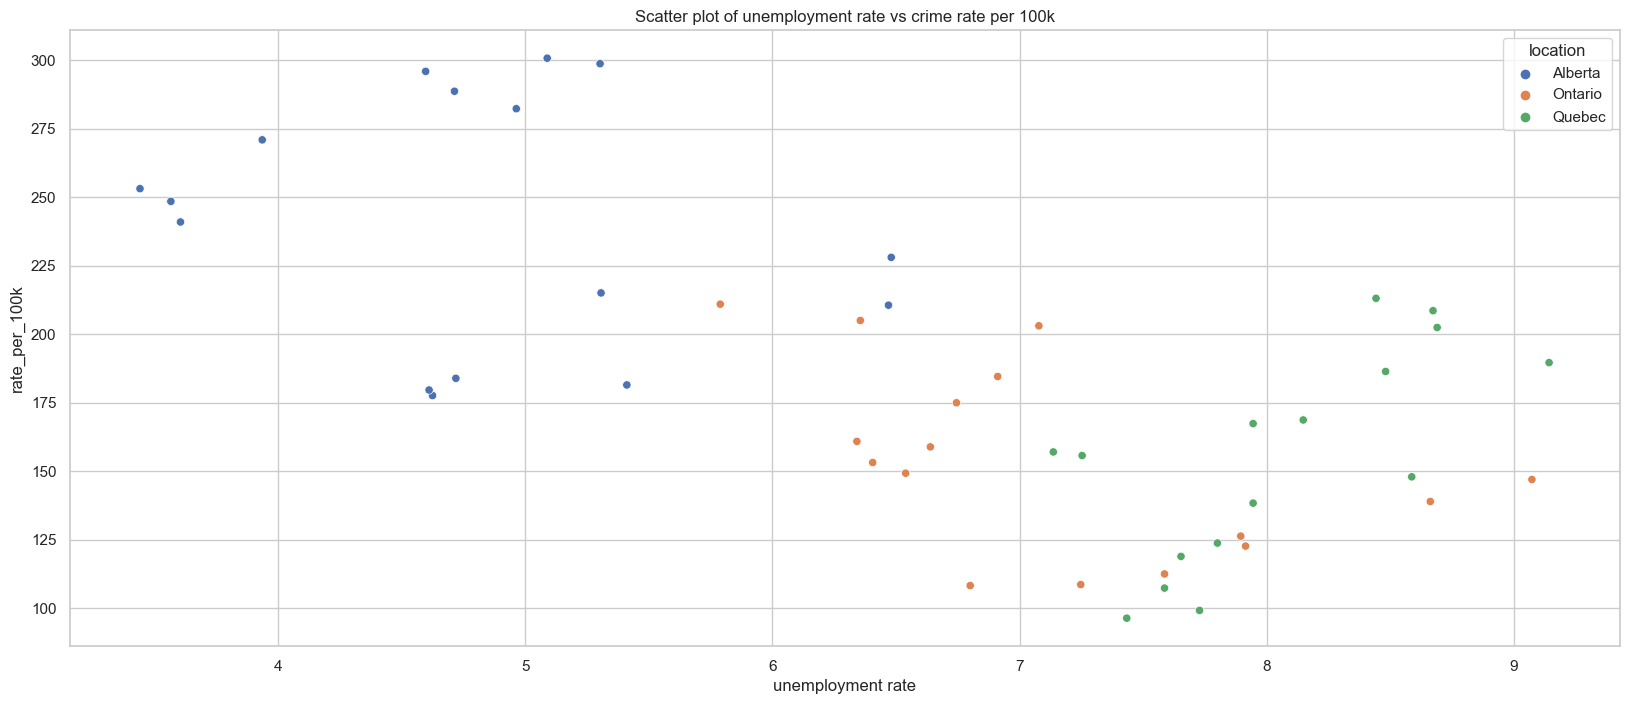

In [151]:
timespan = np.arange(2000,2016,1).tolist() #returns a list of integers
timespan=list(map(str,timespan)) #using map function to convert each element to string and reassigning to same variable
unemployment['year'] = unemployment['When'].str[-4:] #create a new column by extracting year values from When column
df_unemployment = unemployment[unemployment['year'].isin(timespan)] #Filtering timespan by the years 2000 - 2015
df_unemployment = df_unemployment[df_unemployment['AgeGroup']=='15 years and over'] #Filtering age group by 15 and over

df_unemployment = df_unemployment.melt(id_vars=['year','When','AgeGroup','Sex'],var_name='location',value_name='unemployment rate') #unpivot all the province column names to row values to align with Canada crimes dataframe

df_unemployment = df_unemployment.groupby(['year','location'])['unemployment rate'].mean().reset_index() #taking avg unemployment rate grouped by province and year

df6 = canada_crimes.groupby(['year','location'])['rate_per_100k'].mean().reset_index() #preparing the crimes dataframe for merge

df_unemployment = df_unemployment.loc[df_unemployment['location']!= 'Canada'] #dropping all rows where location = Canada

#making the province names in both dataframes identical to each other

df_unemployment['location'] = df_unemployment['location'].replace({'BritishColumbia':'British Columbia', 'NewBrunswick':'New Brunswick','NewfoundlandAndLabdrador':'Newfoundland and Labrador','NovaScotia':'Nova Scotia','PrinceEdwardIsland':'Prince Edward Island'})

### At this point, I realized that one dataframe includes Northwest territories while the other does not, so merging the two dataframes is pointless. Rather, I will compare between Ontario, Albert and Quebec

province_selection = ['Alberta','Ontario','Quebec']
df_unemployment = df_unemployment[df_unemployment['location'].isin(province_selection)]
df6['location']=df6['location'].str.strip() #remove whitepsace from province names
df6=df6[df6['location'].isin(province_selection)] #limit the provinces to Ontario, Quebec, Alberta
df6=df6[df6['year'].isin(np.arange(2000,2016,1))] #limit the timespan to 2000 - 2015

df_unemployment['year']=df_unemployment['year'].astype(int) #convert column of dtype object to int before merging

merged_df = pd.merge(df_unemployment,df6,on=['year','location']) #merge both dataframes

correlation = merged_df['unemployment rate'].corr(merged_df['rate_per_100k'])

print(f'Correlation Coefficient: {correlation}')

plt.figure(figsize=(20,8))
sns.scatterplot(data=merged_df,x='unemployment rate',y='rate_per_100k',hue='location')
plt.title('Scatter plot of unemployment rate vs crime rate per 100k')